https://github.com/pymc-devs/pymc3/issues/3012

In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, a, b]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 568.50draws/s]
The acceptance probability does not match the target. It is 0.8910600584876974, but should be close to 0.8. Try to increase the number of tuning steps.


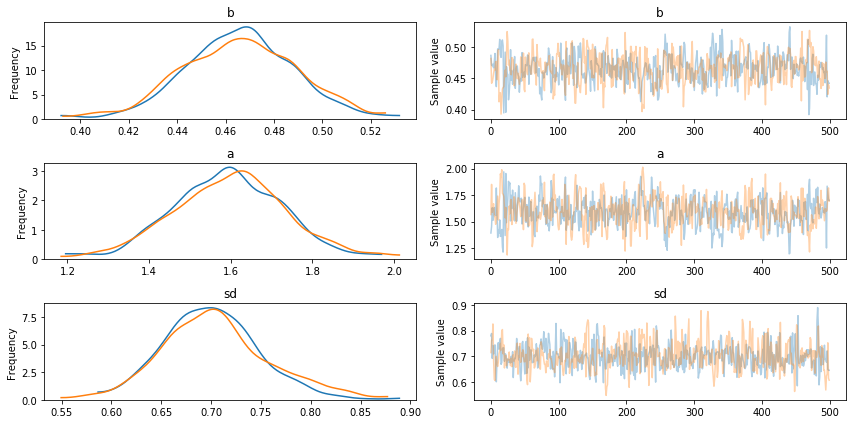

In [2]:
X = np.random.uniform(0., 10., size=100)
y = X*.5 + 1.5 + np.random.randn(100)*.8

with pm.Model() as m:
    X_ = pm.Uniform('x', 0., 10., observed=X)
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs', a+b*X_, sd, observed=y)
    trace = pm.sample()

pm.traceplot(trace);

In [3]:
with m:
    ppc = pm.sample_ppc(trace, 100)

100%|██████████| 100/100 [00:00<00:00, 384.58it/s]


In [4]:
ppc['obs'].shape

(100, 100)

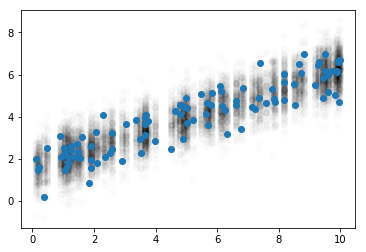

In [5]:
plt.plot(X, ppc['obs'].T, 'ko', alpha=.01);
plt.plot(X, y, 'o');

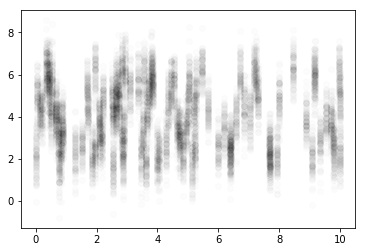

In [6]:
plt.plot(ppc['x'], ppc['obs'].T, 'ko', alpha=.01);

In [7]:
with pm.Model() as m2:
    X_ = pm.Uniform('x', 0., 10., shape=X.shape)
    pm.Normal('obs1', X_, .01, observed=X)
    
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs2', a+b*X_, sd, observed=y)
    trace = pm.sample()
    ppc = pm.sample_ppc(trace, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, a, b, x]
100%|██████████| 200/200 [00:00<00:00, 733.29it/s]


In [8]:
ppc['obs1'].shape

(200, 100)

In [9]:
ppc['obs2'].shape

(200, 100)

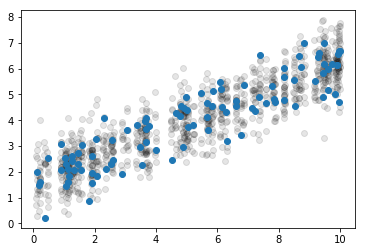

In [10]:
ind = slice(0, 10)
plt.plot(ppc['obs1'][ind,:], ppc['obs2'][ind,:], 'ko', alpha=.1);
plt.plot(X, y, 'o');

In [11]:
from pymc3.model import modelcontext
from tqdm import tqdm
from collections import defaultdict
from pymc3.distributions.distribution import draw_values

def sample_ppc(trace, samples=None, model=None, vars=None, size=None,
               random_seed=None, progressbar=True):
    """Generate posterior predictive samples from a model given a trace.

    Parameters
    ----------
    trace : backend, list, or MultiTrace
        Trace generated from MCMC sampling. Or a list containing dicts from
        find_MAP() or points
    samples : int
        Number of posterior predictive samples to generate. Defaults to the length of `trace`
    model : Model (optional if in `with` context)
        Model used to generate `trace`
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.observed_RVs`.
    size : int
        The number of random draws from the distribution specified by the parameters in each
        sample of the trace.
    random_seed : int
        Seed for the random number generator.
    progressbar : bool
        Whether or not to display a progress bar in the command line. The bar shows the percentage
        of completion, the sampling speed in samples per second (SPS), and the estimated remaining
        time until completion ("expected time of arrival"; ETA).

    Returns
    -------
    samples : dict
        Dictionary with the variables as keys. The values corresponding to the
        posterior predictive samples.
    """
    len_trace = len(trace)
    try:
        nchain = trace.nchains
    except AttributeError:
        nchain = 1

    if samples is None:
        samples = len(trace)

    model = modelcontext(model)

    if vars is None:
        vars = model.observed_RVs

    if random_seed is not None:
        np.random.seed(random_seed)

    indices = np.random.randint(0, nchain * len_trace, samples)

    if progressbar:
        indices = tqdm(indices, total=samples)
    
    varnames = [var.name for var in vars]
    var_values = list(zip(varnames, 
                          draw_values(vars, point=model.test_point, size=size)))
    ppc_trace = dict()
    for varname, value in var_values:
        ppc_trace[varname] = np.zeros((samples, ) + value.shape, value.dtype)

    try:
        ppc = defaultdict(list)
        for slc, idx in enumerate(indices):
            if nchain > 1:
                chain_idx, point_idx = np.divmod(idx, len_trace)
                param = trace._straces[chain_idx].point(point_idx)
            else:
                param = trace[idx]

            values = draw_values(vars, point=param, size=size)
            for k, v in zip(vars, values):
                ppc_trace[k.name][slc] = v

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return ppc_trace

In [12]:
with pm.Model() as m:
    X_ = pm.Uniform('x', 0., 10., observed=X)
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs', a+b*X_, sd, observed=y)
    
    ppc = sample_ppc(trace, 200)

100%|██████████| 200/200 [00:00<00:00, 224.67it/s]


In [13]:
ppc['x'].shape

(200, 100)

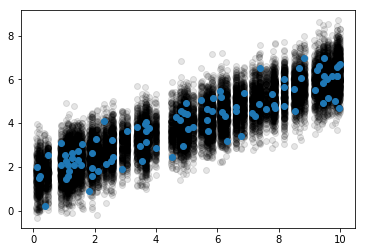

In [15]:
plt.plot(ppc['x'], ppc['obs'], 'ko', alpha=.1);
plt.plot(X, y, 'o');

In [16]:
with m:
    Xnew = pm.Uniform('xnew', 0., 10.)
    Ynew = pm.Normal('ynew', a+b*Xnew, sd)
    ppc = sample_ppc(trace, 200, vars=[Xnew, Ynew])

100%|██████████| 200/200 [00:10<00:00, 19.57it/s]


In [17]:
ppc['xnew'].shape, ppc['ynew'].shape

((200,), (200,))

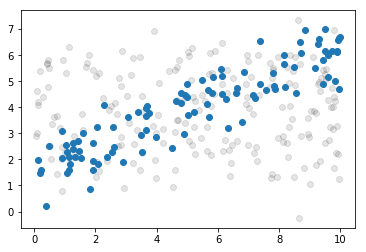

In [18]:
plt.plot(ppc['xnew'], ppc['ynew'], 'ko', alpha=.1);
plt.plot(X, y, 'o');